# **DATA1030 Final**
Julien Song

#### **INSTRUCTIONS**

**[EdStem:](https://edstem.org/us/courses/83381/discussion/6934935)**

- Come up with a classification or regression problem!
- The goal of the final project is to develop a supervised ML pipeline from scratch by following the eight steps outlined in the lecture notes.
- There are three main reasons why a ML problem is difficult:
    1) missing data ✔️
    2) dataset is not IID (e.q., time series data, or one object is described by multiple data points - group structure)
    3) dataset is large (more than 100k points) so it is difficult to manage it on your laptop
- Choose a dataset with at least one of these difficulties!

**[Rubric](https://docs.google.com/document/d/1s2hjikSGQnCgZK8l3hOM2z7nmjIdzYSL5eFY7Ehteyw/edit?tab=t.0):**
- Select a dataset and have an interesting/valuable/relevant classification or regression problem in mind to solve
- The purpose of the semester-long project is to give you hands-on experience working with a machine learning pipeline. For the final presentation, the focus is on cross validation, the algorithms and parameters you tried, scores and uncertainties, and model explanations. The presentation is intended as a summary of your final project report.

1) EDA
2) splitting
3) preprocessing
4) evaluation metric
5) ML models
6) hyperparamter tuning
7) interpretability

#### **PROJECT**

**Topic:**
- predicting survival outcome of heart failure patients

**Data:**
- PhysioNet
- [Hospitalized patients with heart failure: integrating electronic healthcare records and external outcome data](https://physionet.org/content/heart-failure-zigong/1.3/)
- Zhang, Z., Cao, L., Zhao, Y., Xu, Z., Chen, R., Lv, L., & Xu, P. (2022). Hospitalized patients with heart failure: integrating electronic healthcare records and external outcome data (version 1.3). *PhysioNet*. RRID:SCR_007345. https://doi.org/10.13026/5m60-vs44
- [original publication](https://www.nature.com/articles/s41597-021-00835-9): <br>
        Zhang Z, Cao L, Chen R, Zhao Y, Lv L, Xu Z, Xu P. Electronic healthcare records and external outcome data for hospitalized patients with heart failure. Sci Data. 2021 Feb 5;8(1):46. doi: 10.1038/s41597-021-00835-9. PMID: 33547290; PMCID: PMC7865067
- patients who were admitted to a hospital in Sichuan, China between 2016 and 2019
- 168 variables for 2,008 patients with heart failure
- Medications administered during the hospitalization are recorded in dat_md.csv. 
- Subsequent admission & mortality = follow‐up at 28 days, 3 months, 6 months <br>
-> classification problem (discrete ordinal)

In [1]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np  

# EDA
import seaborn as sns  
import matplotlib.pyplot as plt  

# splitting
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder  
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import KNNImputer

# models
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

# metrics
from sklearn.metrics import f1_score

# interpretability
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
import shap

In [2]:
# IMPORT DATA

# csv to df
df_og = pd.read_csv('heartfailure-ehr-data/dat.csv')

# display all
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print(df_og.head())
# print(df_og.describe())
# print(df_og.shape) # (2008, 167)

In [3]:
# FINAL DF
df = df_og.copy()

# print(df.columns)

# create 1 y var:
# initial y options based on project goal of predicting survival outcome
drop_cols = ["Unnamed: 0", "inpatient.number", "outcome.during.hospitalization", "death.within.28.days", "re.admission.within.28.days", "death.within.3.months", "re.admission.within.3.months", 
             "death.within.6.months", "re.admission.within.6.months", "time.of.death..days.from.admission.", "re.admission.time..days.from.admission.", 
             "return.to.emergency.department.within.6.months", "time.to.emergency.department.within.6.months"]

# make y categorical -> death @ hosp, 28d, 3mo, 6mo, alive 6mo
y_series = pd.Series(name = 'survival.outcome')  
for row in range(len(df)):
    if df.loc[row, "outcome.during.hospitalization"] == 'Dead':
        outcome = 'death.at.hospital'
    elif df.loc[row, "death.within.28.days"] == 1:
        outcome = 'death.within.28d'
    elif df.loc[row, "death.within.3.months"] == 1:
        outcome = 'death.within.3m'
    elif df.loc[row, "death.within.6.months"] == 1:
        outcome = 'death.within.6m'
    else:
        outcome = 'alive.after.6m'
    y_series[row] = outcome

# drop original y cols 
df = df.drop(columns=drop_cols) 

# drop column with all missing values:
# which columns completely missing:
# for col in df.columns:
#     if df[col].isnull().sum() == len(df):
#         print(col)
# cholinesterase

df = df.drop(columns=['cholinesterase'])

df['survival.outcome'] = y_series

In [4]:
# EDA
# final dataset
X = df.loc[:, df.columns != 'survival.outcome']
y = df['survival.outcome']

# print(y.head())
print(y.shape) # (2008,)
# # print(X.head())
print(X.shape) # (2008, 154)

(2008,)
(2008, 153)


In [5]:
# EDA
# check class balance:
print(y.value_counts(normalize=False))
print(y.value_counts(normalize=True))

# iid & imbalanced
# -> kfold shuffle, class_weight, f-score

survival.outcome
alive.after.6m       1951
death.within.28d       28
death.within.6m        15
death.at.hospital      11
death.within.3m         3
Name: count, dtype: int64
survival.outcome
alive.after.6m       0.971614
death.within.28d     0.013944
death.within.6m      0.007470
death.at.hospital    0.005478
death.within.3m      0.001494
Name: proportion, dtype: float64


In [6]:
# data types

# continuous:
continuous_ftrs = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# categorical:
all_cat_ftrs = X.select_dtypes(include=['object', 'category', 'bool']).columns
# ordinal vs. nominal:
# for col in all_cat_ftrs:
#     print(f"\n{col}: {X[col].unique()}")
# ordinal: 
    # NYHA.cardiac.function.classification: ['III' 'II' 'IV']
    # Killip.grade: ['III' 'I' 'II' 'IV']
    # consciousness: ['Clear' 'ResponsiveToPain' 'ResponsiveToSound' 'Nonresponsive']
    # respiratory.support.: [nan 'NIMV' 'IMV']
    # ageCat: ['(69,79]' '(59,69]' '(79,89]' '(49,59]' '(89,110]' '(29,39]' '(39,49]' '(21,29]']
# binary (but want to assign 0/1):
    # admission.way: ['NonEmergency' 'Emergency']
    # type.II.respiratory.failure: ['NonTypeII' 'TypeII']
    # oxygen.inhalation: ['OxygenTherapy' 'AmbientAir']
ordinal_ftrs = ['NYHA.cardiac.function.classification', 'Killip.grade', 'consciousness', 'respiratory.support.', 'ageCat',
                'admission.way', 'type.II.respiratory.failure', 'oxygen.inhalation'] 
ordinal_cats = [['II', 'III', 'IV'],  # NYHA.cardiac.function.classification
                ['I', 'II', 'III', 'IV'],  # Killip.grade
                ['Clear', 'ResponsiveToSound', 'ResponsiveToPain', 'Nonresponsive'],  # consciousness
                ['NA', 'NIMV', 'IMV'],  # respiratory.support.
                ['(21,29]', '(29,39]', '(39,49]', '(49,59]', '(59,69]', '(69,79]', '(79,89]', '(89,110]'],  # ageCat
                ['NonEmergency', 'Emergency'],  # admission.way
                ['NonTypeII', 'TypeII'],  # type.II.respiratory.failure
                ['AmbientAir', 'OxygenTherapy']  # oxygen.inhalation
                ]
# nominal:
nominal_ftrs = list(set(all_cat_ftrs) - set(ordinal_ftrs))

In [7]:
# EDA

# continuous = histogram
# ordinal = barplot (correct order)
# categorical = barplot
# continuous v. continuous = scatterplot, heatmap
# continuous v. categorical = category-specific histogram, boxplot, violin plot (>3-4)
# categorical v. categorical = stacked barplot

In [8]:
# EDA
# visualize individual variables:

# continuous = histogram
# for col in continuous_ftrs:
#     plt.figure(figsize=(4, 3)) # size to manage cell output
#     plt.hist(X[col])#, kde=True)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()

In [9]:
# EDA
# visualize individual variables:

# nominal = barplot
# for col in nominal_ftrs:
#     plt.figure(figsize=(4, 3)) # size to manage cell output
#     sns.countplot(data=X, x=col)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()


In [10]:
# EDA
# visualize individual variables:

# ordinal = barplot (in given order)
# for col in  ordinal_ftrs:
#     plt.figure(figsize=(4, 3)) # size to manage cell output
#     order = ordinal_cats[ordinal_ftrs.index(col)]
#     sns.countplot(data=X, x=col, order=order)
#     plt.title(f'Distribution of {col}')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.show()

In [11]:
# EDA
# visualize outcome vs. features:

# categorical v. categorical = stacked bar plot
# for col in nominal_ftrs:
#     count_matrix = df.groupby([col, 'survival.outcome']).size().unstack()
#     count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

#     count_matrix_norm.plot(kind='bar', stacked=True, cmap='Paired', figsize=(4, 3)) # size to manage cell output
#     plt.title(f'{col} vs. Survival Outcome')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.legend(title='Survival Outcome', fontsize='small')
#     # plt.tight_layout()
#     plt.show()

# for col in ordinal_ftrs:
#     count_matrix = df.groupby([col, 'survival.outcome']).size().unstack()
#     count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)

#     count_matrix_norm.plot(kind='bar', stacked=True, cmap='Paired', figsize=(4, 3)) # size to manage cell output
#     plt.title(f'{col} vs. Survival Outcome')
#     plt.xlabel(col)
#     plt.ylabel('Count')
#     plt.legend(title='Survival Outcome', fontsize='small')
#     # plt.tight_layout()
#     plt.show()

In [12]:
# EDA
# continuous x v. outcome:

# categorical x continuous = category-specific histograms, box plot, violin plot
# for col in continuous_ftrs:
#     df[[col,'survival.outcome']].boxplot(by='survival.outcome', figsize=(4,3)) # size to manage cell output
#     # plt.title(f'survival outcome by {col}')
#     plt.xlabel('survival outcome')
#     plt.ylabel(col)
#     plt.tight_layout()
#     plt.xticks(rotation=45)
#     plt.show()

In [13]:
# EDA
# missing values
# how many missing values per column
missing_vals = df.isnull().sum()
missing_perc = (missing_vals / len(df)) * 100

# print(missing_vals)
# print(missing_perc)
# for col in df.columns:
#     miss = missing_vals[col]
#     perc = missing_perc[col]
#     if miss > 0:
#         print(f"{col}: {perc:.2f}%")

# cols with missing values 100-90, 80-90, 70-79, 60-69, 50-59, 40-49, 30-39, 20-29, 10-19, 1-9%
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9%', '10-19%', '20-29%', '30-39%', '40-49%', '50-59%', '60-69%', '70-79%', '80-89%', '90-100%']
df_missing = pd.DataFrame({'column': missing_vals.index, 'missing_count': missing_vals.values})
df_missing['missing_perc'] = (df_missing['missing_count'] / len(df_og)) * 100
df_missing['missing_bin'] = pd.cut(df_missing['missing_perc'], bins=bins, labels=labels, right=False)
missing_bin_counts = df_missing['missing_bin'].value_counts().sort_index()
print(missing_bin_counts)

# total missing values in dataset:
total_missing = missing_vals.sum()
total_values = df_og.size
overall_missing_perc = (total_missing / total_values) * 100
print(f"total missing values: {total_missing}")
print(f"overall missing percentage: {overall_missing_perc:.2f}%")

cont_missing = df[continuous_ftrs].isnull().sum().sum()
cont_missing_perc = (cont_missing / (len(continuous_ftrs) * len(df))) * 100
print(f"total missing values in continuous features: {cont_missing}")
print(f"total missing percentage in continuous features: {cont_missing_perc:.2f}%")
nom_missing = df[nominal_ftrs].isnull().sum().sum()
nom_missing_perc = (nom_missing / (len(nominal_ftrs) * len(df))) * 100
print(f"total missing values in nominal features: {nom_missing}")
print(f"total missing percentage in nominal features: {nom_missing_perc:.2f}%")
ord_missing = df[ordinal_ftrs].isnull().sum().sum()
ord_missing_perc = (ord_missing / (len(ordinal_ftrs) * len(df))) * 100
print(f"total missing values in ordinal features: {ord_missing}")
print(f"total missing percentage in ordinal features: {ord_missing_perc:.2f}%")

missing_bin
0-9%       103
10-19%       7
20-29%       3
30-39%       1
40-49%       0
50-59%      25
60-69%       2
70-79%       4
80-89%       3
90-100%      6
Name: count, dtype: int64
total missing values: 57562
overall missing percentage: 17.17%
total missing values in continuous features: 55569
total missing percentage in continuous features: 19.91%
total missing values in nominal features: 27
total missing percentage in nominal features: 0.22%
total missing values in ordinal features: 1966
total missing percentage in ordinal features: 12.24%


In [14]:
# SPLITTING

# split during model iteration over multiple random states
random_states = [42, 52, 62, 72, 82]

In [15]:
# PREPROCESSING

# preprocess during model iteration over multiple random states
# random_states = [42, 52, 62, 72, 82]

# encode & impute
# continuous -> StandardScaler
# nominal -> OneHotEncoder
# ordinal -> OrdinalEncoder

# IterativeImputer not reasonable with iteration through such high # features
# -> use KNN Imputer

In [16]:
# MODELS
# logistic regression (classification)

# nominal transformer:
nominal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                      ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
# ordinal transformer:
# We need to replace the NaN with a string first!
ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
                                      ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
# continuous transformer: 
# KNN Imputer
numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=10)),
                                      ('scaler', StandardScaler())])

# preprocessor:
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, continuous_ftrs),
                                                ('cat', nominal_transformer, nominal_ftrs),
                                                ('ord', ordinal_transformer, ordinal_ftrs)])

# hyperparameter tuning:
lr_param_grid = {'logreg__penalty': ['l2'], 
                 'logreg__C': np.logspace(-3,0,10),  
                 'logreg__max_iter': [1000]} 

# initialize result collection:
lr_test_scores = []
lr_models = []

# model:
for rs in random_states:
        # splitting: stratified kfold
        kf1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs) #n≤3 bc smallest class size = 3
        for other_idx, test_idx in kf1.split(X, y):
          X_other = X.iloc[other_idx]
          X_test = X.iloc[test_idx]
          y_other = y.iloc[other_idx] # y transformed
          y_test = y.iloc[test_idx]

        # pipeline:
        model = LogisticRegression(random_state = rs, class_weight='balanced')  
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('logreg', model)])

        # cross validation: 
        kf2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=rs) #n≤2 bc smallest class size = 2
        grid = GridSearchCV(pipeline, param_grid=lr_param_grid, scoring = 'f1_weighted', cv=kf2, return_train_score = True, verbose=True)
    
        # model fitting:
        grid.fit(X_other, y_other)

        # results:
        lr_models.append(grid)
        y_test_pred = lr_models[-1].predict(X_test)
        # test-score = f1_weighted
        test_score = f1_score(y_test, y_test_pred, average='weighted')
        lr_test_scores.append(test_score)

# best model:
lr_best_model_idx = np.argmax(lr_test_scores)
lr_best_model = lr_models[lr_best_model_idx]
lr_best_hyperparams = lr_best_model.best_params_  
lr_best_test_score = lr_test_scores[lr_best_model_idx]

print("best model hyperparameters: ", lr_best_hyperparams)
print("best model test f1: ", lr_best_test_score)

# results (plot later)
lr_mean = np.mean(lr_test_scores)
lr_std = np.std(lr_test_scores)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


KeyboardInterrupt: 

In [ ]:
# MODELS
# SVC

# same trasforners as log reg

# hyperparameter tuning:
svc_param_grid = {'svc__C': np.logspace(-3,0,10),
                  'svc__gamma': np.logspace(-3,0,10)} 

# initialize result collection:
svc_test_scores = []
svc_models = []

# model:
for rs in random_states:
        # splitting: stratified kfold  
        kf1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs) #n≤3 bc smallest class size = 3
        for other_idx, test_idx in kf.split(X, y):
          X_other = X.iloc[other_idx]
          X_test = X.iloc[test_idx]
          y_other = y.iloc[other_idx] # y transformed
          y_test = y.iloc[test_idx]

        # pipeline:
        model = SVC(random_state = rs, class_weight='balanced')  
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('svc', model)])

        # cross validation: 
        kf2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=rs) #n≤2 bc smallest class size = 2
        grid = GridSearchCV(pipeline, param_grid=svc_param_grid, scoring = 'f1_weighted',
                            cv=kf2, return_train_score = True, verbose=True)
    
        # model fitting:
        grid.fit(X_other, y_other)

        # results:
        svc_models.append(grid)
        y_test_pred = svc_models[-1].predict(X_test)
        # test-score = f1_weighted
        test_score = f1_score(y_test, y_test_pred, average='weighted')
        svc_test_scores.append(test_score)


# best model:
svc_best_model_idx = np.argmax(svc_test_scores)
svc_best_model = svc_models[svc_best_model_idx]
svc_best_hyperparams = svc_best_model.best_params_  
svc_best_test_score = svc_test_scores[svc_best_model_idx]

print("best model hyperparameters: ", svc_best_hyperparams)
print("best model test f1: ", svc_best_test_score)

# results (plot later)
svc_mean = np.mean(svc_test_scores)
svc_std = np.std(svc_test_scores)

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
Fitting 2 folds for each of 100 candidates, totalling 200 fits
best model hyperparameters:  {'svc__C': np.float64(0.46415888336127775), 'svc__gamma': np.float64(0.004641588833612777)}
best model test f1:  0.957290794077231


In [ ]:
# MODELS
# RFC

# preprocessing: don't impute tree models -> trees only need preprocessing to numeric
# same categorical encoders as logreg & SVC
# # nominal encoder:
# nominal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                 ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
# # ordinal encoder:
# ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
#                                 ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
# continuous encoder: no imputation for tree models

# preprocessor:
preprocessor = ColumnTransformer(transformers=[('cat', nominal_transformer, nominal_ftrs),
                                                ('ord', ordinal_transformer, ordinal_ftrs)])

# hyperparameter tuning:
rfc_param_grid = {'rfc__n_estimators': [10,50,100,500],
                  'rfc__max_features': np.linspace(0.1,0.9,5),
                  'rfc__max_depth': [1,10,30]} 

# initialize result collection:
rfc_test_scores = []
rfc_models = []

# model:
for rs in random_states:
        # splitting: kfold on other
        kf1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs) #n≤3 bc smallest class size = 3
        for other_idx, test_idx in kf1.split(X, y):
          X_other = X.iloc[other_idx]
          X_test = X.iloc[test_idx]
          y_other = y.iloc[other_idx] # y transformed
          y_test = y.iloc[test_idx]

        # pipeline:
        model = RandomForestClassifier(random_state=rs, class_weight='balanced_subsample') # balanced_subsample for imbalanced
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('rfc', model)])

        # cross validation: 
        kf2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=rs) #n≤2 bc smallest class size = 2
        grid = GridSearchCV(pipeline, param_grid=rfc_param_grid, scoring = 'f1_weighted',
                            cv=kf2, return_train_score = True, verbose=True)
    
        # model fitting:
        grid.fit(X_other, y_other)

        # results
        rfc_models.append(grid)
        y_test_pred = rfc_models[-1].predict(X_test)
        # test-score = f1_weighted
        test_score = f1_score(y_test, y_test_pred, average='weighted')
        rfc_test_scores.append(test_score)

# best model:
rfc_best_model_idx = np.argmax(rfc_test_scores)
rfc_best_model = rfc_models[rfc_best_model_idx]
rfc_best_hyperparams = rfc_best_model.best_params_  
rfc_best_test_score = rfc_test_scores[rfc_best_model_idx]

print("best model hyperparameters: ", rfc_best_hyperparams)
print("best model test f1: ", rfc_best_test_score)

# results (plot later)
rfc_mean = np.mean(rfc_test_scores)
rfc_std = np.std(rfc_test_scores)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
Fitting 2 folds for each of 60 candidates, totalling 120 fits
Fitting 2 folds for each of 60 candidates, totalling 120 fits
Fitting 2 folds for each of 60 candidates, totalling 120 fits
Fitting 2 folds for each of 60 candidates, totalling 120 fits
best model hyperparameters:  {'rfc__max_depth': 30, 'rfc__max_features': np.float64(0.9), 'rfc__n_estimators': 10}
best model test f1:  0.9580779018335805


In [ ]:
# MODELS
# XGB 

# preprocessing: don't impute tree models -> trees only need preprocessing to numeric
# same preprocessor as RFC
# # nominal encoder:
# nominal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#                                 ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])
# # ordinal encoder:
# ordinal_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
#                                 ('ordinal', OrdinalEncoder(categories = ordinal_cats))])
# continuous encoder: no imputation for tree models

# # preprocessor:
# preprocessor = ColumnTransformer(transformers=[('cat', nominal_transformer, nominal_ftrs),
#                                                 ('ord', ordinal_transformer, ordinal_ftrs)])

# hyperparameter tuning:
xgb_param_grid = {'xgb__n_estimators': [10,50,100], 
                  'xgb__max_depth': [5,30,50],
                  'xgb__learning_rate': [0.01, 0.05, 0.1],
                  'xgb__reg_lambda': np.logspace(-2,2,5),
                  'xgb__subsample': [0.3, 0.5, 0.7]}

# initialize result collection:
xgb_test_scores = []
xgb_models = []
xgb_test_sets = [] # best model -> save test set for cm

# y label encoder: (not in preprocessor)
# fit on the full set (y) to create a stable mapping label -> no leakage bc only records which string label maps to which integer, doesn't learn relationship between X & y 
y_labenc = LabelEncoder()
y_labenc.fit(y)

# model:
for rs in random_states:
        # splitting: stratified kfold
        kf1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=rs) #n≤3 bc smallest class size = 3
        for other_idx, test_idx in kf1.split(X, y):
          X_other = X.iloc[other_idx]
          X_test = X.iloc[test_idx]
          y_other = y.iloc[other_idx] # y transformed
          y_test = y.iloc[test_idx]

        # transform y other & test using label encoder fitted on full y
        y_other_enc = y_labenc.transform(y_other)
        y_test_enc = y_labenc.transform(y_test)

        # pipeline:
        # model = xgboost.XGBClassifier(early_stopping_rounds=40, enable_categorical=True) # true/false
        model = xgboost.XGBClassifier(enable_categorical=True)  
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('xgb', model)])
        
        # cross validation: 
        kf2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=rs) #n≤2 bc smallest class size = 2
        grid = GridSearchCV(pipeline, param_grid=xgb_param_grid, scoring = 'f1_weighted',
                            cv=kf2, return_train_score=True, verbose=True, error_score='raise')
    
        # model fitting:
        # no early stopping with GridSearchCV
        class_weights = compute_sample_weight(class_weight='balanced', y=y_other_enc)
        grid.fit(X_other, y_other_enc, xgb__sample_weight=class_weights, xgb__verbose=False) # verbose = validation_0-mlogloss output

        # results
        xgb_models.append(grid)
        y_test_pred = xgb_models[-1].predict(X_test)

        # test-score = f1_weighted
        test_score = f1_score(y_test_enc, y_test_pred, average='weighted')
        xgb_test_scores.append(test_score)
        xgb_test_sets.append((X_test, y_test_enc))

        # sanity check
        # print(test_score)

# best model:
xgb_best_model_idx = np.argmax(xgb_test_scores)
xgb_best_model = xgb_models[xgb_best_model_idx]
xgb_best_hyperparams = xgb_best_model.best_params_  
xgb_best_test_score = xgb_test_scores[xgb_best_model_idx]

print("best model hyperparameters: ", xgb_best_hyperparams)
print("best model test f1: ", xgb_best_test_score)

# results (plot later)
xgb_mean = np.mean(xgb_test_scores)
xgb_std = np.std(xgb_test_scores)

Fitting 2 folds for each of 405 candidates, totalling 810 fits
Fitting 2 folds for each of 405 candidates, totalling 810 fits
Fitting 2 folds for each of 405 candidates, totalling 810 fits
Fitting 2 folds for each of 405 candidates, totalling 810 fits
Fitting 2 folds for each of 405 candidates, totalling 810 fits
best model hyperparameters:  {'xgb__learning_rate': 0.05, 'xgb__max_depth': 30, 'xgb__n_estimators': 50, 'xgb__reg_lambda': np.float64(1.0), 'xgb__subsample': 0.3}
best model test f1:  0.9699978646166987


In [ ]:
# BEST MODEL

# all 'best' models:
print("lr: ", lr_mean, ", ", lr_std)
print("svc: ", svc_mean, ", ", svc_std)
print("rfc: ", rfc_mean, ", ", rfc_std)
print("xgb: ", xgb_mean, ", ", xgb_std)

# xgb:
# best model hyperparameters:  {'xgb__learning_rate': 0.05, 'xgb__max_depth': 30, 'xgb__n_estimators': 50, 'xgb__reg_lambda': np.float64(0.01), 'xgb__subsample': 0.5}
# best model test f1:  0.9600153034352713

best_model = xgb_best_model
best_X_test, best_y_test = xgb_test_sets[xgb_best_model_idx]

lr:  0.9411238583535871 ,  0.003720000194119701
svc:  0.9483896831638686 ,  0.009935752032979972
rfc:  0.9468757082403811 ,  0.00931753233832749
xgb:  0.9595519771332045 ,  0.009438372944090704


In [ ]:
# BASELINE

# multiclass classification: baseline = predict majority class for all points
# majority class = alive.after.6m = 0
majority_class = 0
y_baseline_pred = [majority_class] * len(best_y_test)
baseline_test_score = f1_score(best_y_test, y_baseline_pred, average='weighted')
print("baseline test f1: ", baseline_test_score)

baseline test f1:  0.9576036563460791


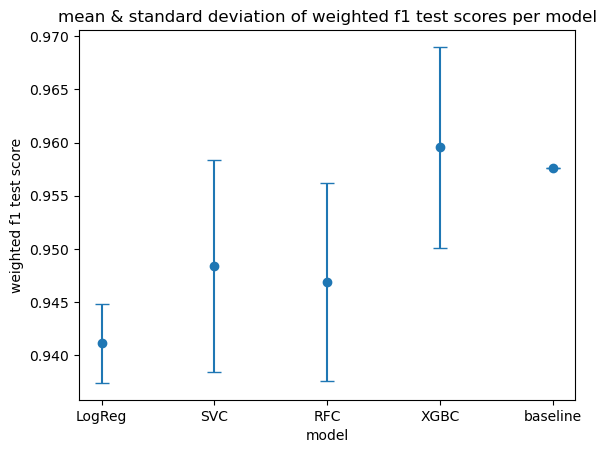

In [ ]:
# RESULTS
# plot means and standard deviations

labels = ['LogReg', 'SVC', 'RFC', 'XGBC', 'baseline']
means = [lr_mean, svc_mean, rfc_mean, xgb_mean, baseline_test_score]
stds = [lr_std, svc_std, rfc_std, xgb_std, 0] # assume baseline std=0  

fig = plt.figure()
plt.errorbar(labels, means, yerr=stds, fmt='o', capsize=5, label='mean with std')
plt.xlabel('model')
plt.ylabel('weighted f1 test score')
plt.title('mean & standard deviation of weighted f1 test scores per model')
plt.show()

fig.savefig("mean_sd.png", dpi=300)

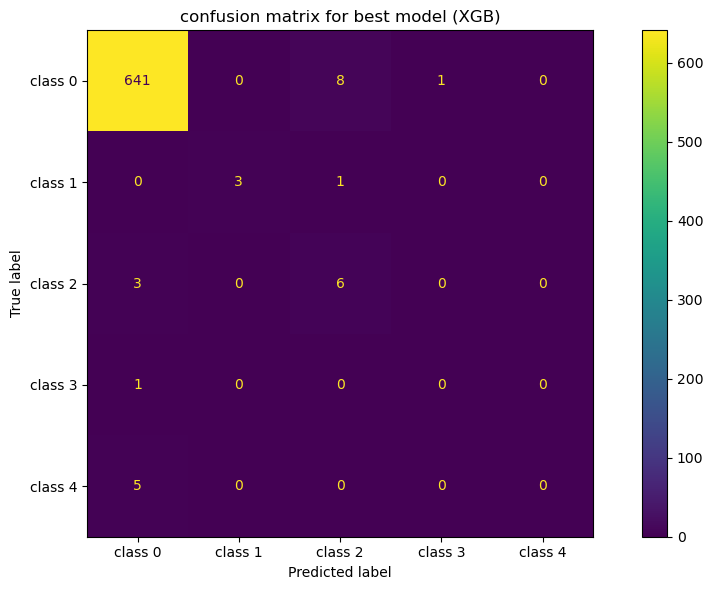

In [ ]:
# INTERPRETABILITY
# confusion matrix
# best model:

# predict:
y_true = best_y_test 
y_pred = best_model.predict(best_X_test)

# overall confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4'])
fig, ax = plt.subplots(figsize=(10,6))
disp.plot(ax=ax)
plt.title('confusion matrix for best model (XGB)')
plt.tight_layout()
plt.show()

fig.savefig("conf_matx.png", dpi=300)

In [ ]:
# INTERPRETABILITY
# global feature importances - xgb feature_importances_
best_model_step = best_model.best_estimator_.named_steps['xgb']
importances = best_model_step.feature_importances_
ftr_names = best_model.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
ftr_importance_df = pd.DataFrame({'feature': ftr_names,
                                  'importance': importances})
ftr_importance_df = ftr_importance_df.sort_values(by='importance', ascending=False) # sort descending

ftr_importance_df

,feature,importance
10,cat__DestinationDischarge_Died,0.108454
26,ord__respiratory.support.,0.084143
19,cat__discharge.department_Cardiology,0.066198
4,cat__occupation_missing,0.065827
12,cat__DestinationDischarge_Home,0.054816
6,cat__admission.ward_Cardiology,0.053379
1,cat__occupation_Others,0.050983
13,cat__DestinationDischarge_Unknown,0.046431
27,ord__ageCat,0.041249
28,ord__admission.way,0.039064


In [ ]:
# INTERPRETABILITY
# local explanations - SHAP

best_pipe = best_model.best_estimator_
preproc = best_pipe.named_steps['preprocessor']
xgb_est = best_pipe.named_steps['xgb']#.get_booster()

X_test_transformed = preproc.transform(best_X_test)
feature_names = preproc.get_feature_names_out()

class_names = list(y_labenc.classes_)

# create explainer (TreeExplainer for tree models)
explainer = shap.TreeExplainer(xgb_est)        # pass the estimator object
shap_values = explainer.shap_values(X_test_transformed)
shap_values = [shap_values[:, :, c] for c in range(n_classes)]

In [ ]:
# INTERPRETABILITY
# local explanations - SHAP
# class 0

class_idx = 0

plt.figure()
shap.summary_plot(shap_values[class_idx], X_test_transformed, feature_names=feature_names, show=False)
ax = plt.gca()            
ax.set_title(f"SHAP summary — class {class_idx}: {class_names[class_idx]}")
plt.tight_layout()

plt.show()

plt.savefig("shap0.png", dpi=300)

NameError: name 'plt' is not defined

<Figure size 640x480 with 0 Axes>

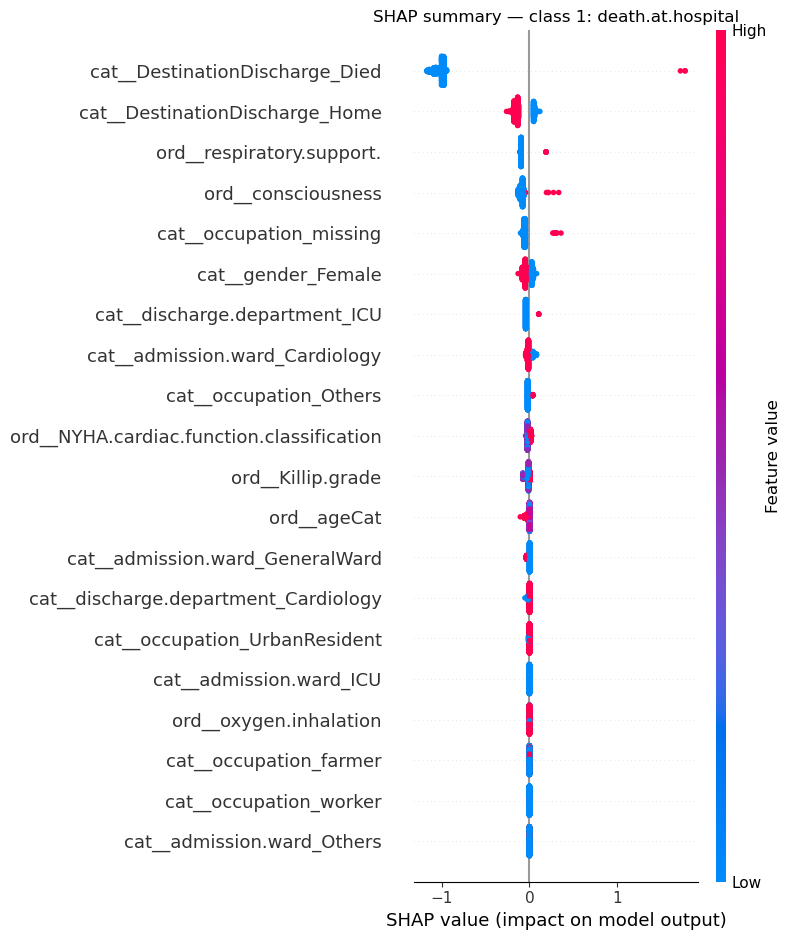

In [ ]:
# INTERPRETABILITY
# local explanations - SHAP
# class 1

class_idx = 1

plt.figure()
shap.summary_plot(shap_values[class_idx], X_test_transformed, feature_names=feature_names, show=False)
ax = plt.gca()            
ax.set_title(f"SHAP summary — class {class_idx}: {class_names[class_idx]}")
plt.tight_layout()

plt.show()

plt.savefig("shap1.png", dpi=300)

<Figure size 640x480 with 0 Axes>

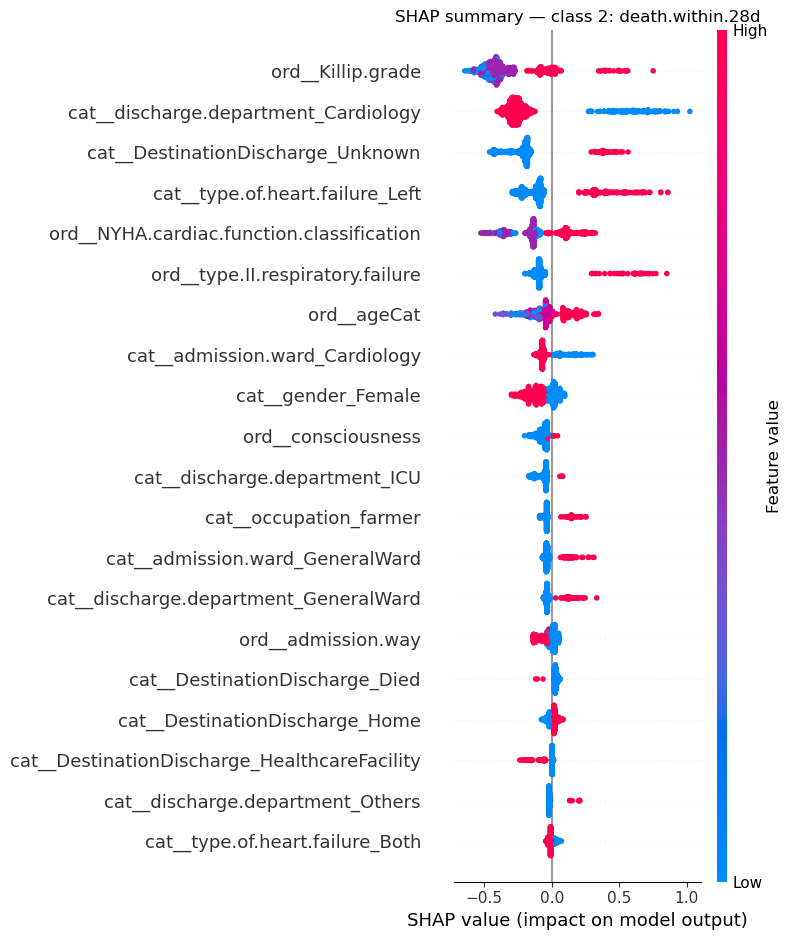

In [ ]:
# INTERPRETABILITY
# local explanations - SHAP
# class 2

class_idx = 2

plt.figure()
shap.summary_plot(shap_values[class_idx], X_test_transformed, feature_names=feature_names, show=False)
ax = plt.gca()            
ax.set_title(f"SHAP summary — class {class_idx}: {class_names[class_idx]}")
plt.tight_layout()

plt.show()

plt.savefig("shap2.png", dpi=300)

<Figure size 640x480 with 0 Axes>

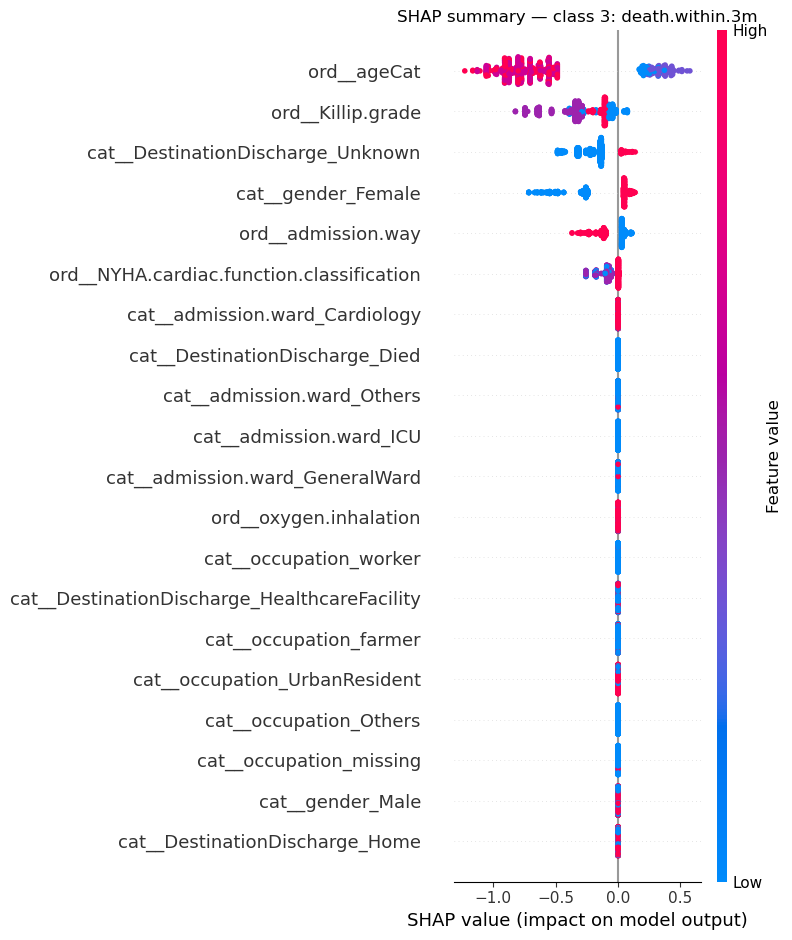

In [ ]:
# INTERPRETABILITY
# local explanations - SHAP
# class 3

class_idx = 3

plt.figure()
shap.summary_plot(shap_values[class_idx], X_test_transformed, feature_names=feature_names, show=False)
ax = plt.gca()            
ax.set_title(f"SHAP summary — class {class_idx}: {class_names[class_idx]}")
plt.tight_layout()

plt.show()

plt.savefig("shap3.png", dpi=300)

<Figure size 640x480 with 0 Axes>

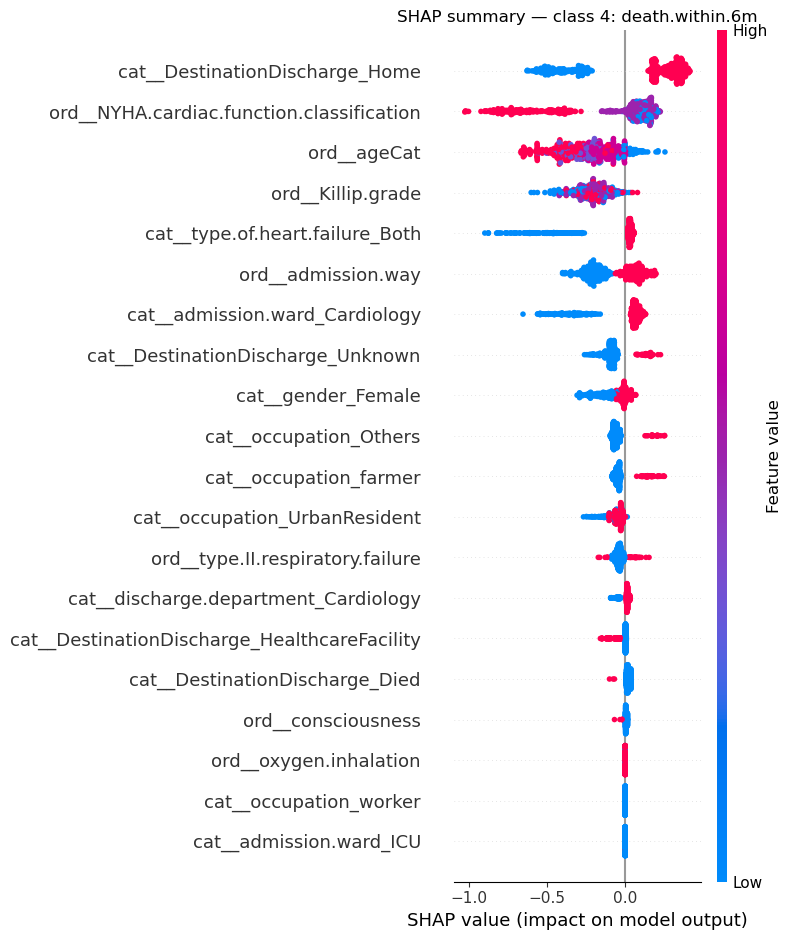

In [ ]:
# INTERPRETABILITY
# local explanations - SHAP
# class 4

class_idx = 4

plt.figure()
shap.summary_plot(shap_values[class_idx], X_test_transformed, feature_names=feature_names, show=False)
ax = plt.gca()            
ax.set_title(f"SHAP summary — class {class_idx}: {class_names[class_idx]}")
plt.tight_layout()

plt.show()

plt.savefig("shap4.png", dpi=300)